#  Определение частей речи с использованием рекуррентных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
* https://notebook.community/sameersingh/uci-statnlp/tutorials/rnn_examples
* https://github.com/bentrevett/pytorch-pos-tagging/blob/master/1_bilstm.ipynb
* https://github.com/Koziev/rupostagger

## Задачи для совместного разбора

1\. Рассмотрите пример работы двунаправленного рекуррентого слоя

![bi-lstm](https://discuss.pytorch.org/uploads/default/original/3X/d/3/d34a27c490e75c1a0a96128c5726ab6656427d90.jpeg)

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
batch_size  =16
seq_len = 5
embedding_dim = 12
x = th.rand(batch_size, seq_len, embedding_dim)

In [ ]:
lstm = nn.LSTM(input_size=embedding_dim, hidden_size=15, batch_first=True, bidirectional=True)

In [ ]:
o, (h, c) = lstm(x)
o.shape, h.shape, c.shape

(torch.Size([16, 5, 30]), torch.Size([2, 16, 15]), torch.Size([2, 16, 15]))

2\. Рассмотрите пример работы многоуровневого рекуррентого слоя

![stacked-rnn](https://lh6.googleusercontent.com/rC1DSgjlmobtRxMPFi14hkMdDqSkEkuOX7EW_QrLFSymjasIM95Za2Wf-VwSC1Tq1sjJlOPLJ92q7PTKJh2hjBoXQawM6MQC27east67GFDklTalljlt0cFLZnPMdhp8erzO)

In [ ]:
lstm = nn.LSTM(input_size=embedding_dim,
               hidden_size=15,
               batch_first=True,
               num_layers=2)
               #bidirectional=True)

In [ ]:
o, (h, c) = lstm(x)

In [ ]:
o.shape, h.shape, c.shape

(torch.Size([16, 5, 15]), torch.Size([2, 16, 15]), torch.Size([2, 16, 15]))

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Считайте файл `pos_data.txt` и создайте на его основе два списка `X` и `y` следующего вида.

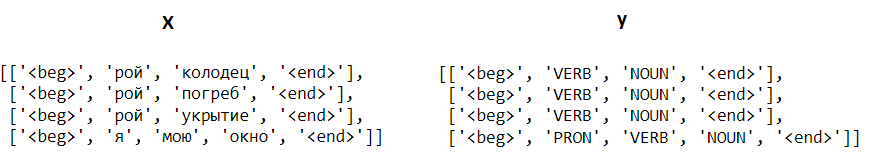

Найдите 75% квантиль распределения длин предложений и удалите из выборки те предложения, которые длиннее данного значения. Выведите на экран пару `(X[0], y[0])` и количество элементов в `X` и `y`.

- [ ] Проверено на семинаре

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path = 'drive/MyDrive/NLP/pos_data.txt'

In [ ]:
import re
with open(path, 'r', encoding='utf-8') as fp:
  X = []
  Y = []
  for line in fp.readlines():
    if '<beg>' in line:
      x = ['<beg>']
      y = ['<beg>']
    elif '<end>' in line:
      x.append('<end>')
      y.append('<end>')
      X.append(x)
      Y.append(y)
    else:
      try:
        word, pos = line.split('\t')[1:3]
        pos = re.findall(r'\w+', pos)[0]
        x.append(word)
        y.append(pos)
      except ValueError:
        pass

In [ ]:
X[0], Y[0]

(['<beg>', 'рой', 'колодец', '<end>'], ['<beg>', 'VERB', 'NOUN', '<end>'])

In [ ]:
import numpy as np

lengths = [len(x) for x in X]
quantile_75 = np.percentile(lengths, 75)
quantile_75

12.0

In [ ]:
X = [
    x for x in X
    if len(x) <= quantile_75
]

In [ ]:
y = [
    y_ for y_ in Y
    if len(y_) <= quantile_75

]

In [ ]:
len(X), len(y)

(776002, 776002)

<p class="task" id="2"></p>

2\. Разделите данные на обучающую и тестовую выборку. Создайте два Vocab на основе загруженных данных: `vocab_X` для слов и `vocab_y` для частей речи. Добавьте в словари специальные токены `<PAD>`, `<UNK>`, `<beg>`, `<end>`. Выведите на экран количество токенов в полученных словарях.

- [ ] Проверено на семинаре

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
  )

In [ ]:
from torchtext.vocab import build_vocab_from_iterator

vocab_X = build_vocab_from_iterator(X_train, specials=['pad', 'unk', 'beg', 'end'])
vocab_X.set_default_index(vocab_X['unk'])
vocab_y = build_vocab_from_iterator(y_train, specials=['pad', 'unk', 'beg', 'end'])
vocab_y.set_default_index(vocab_y['unk'])

In [ ]:
len(vocab_X.get_stoi()), len(vocab_y.get_stoi())

(212080, 22)

<p class="task" id="3"></p>

3\. Создайте класс `POSTaggingDataset`. Реализуйте `__getitem__` таким образом, чтобы он возвращал кортеж `(x, y)`, где x - это набор индексов токенов для предложений на русском языке, а `y` - набор индексов токенов для соответствующих частей речи. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины. Создайте два датасета: для обучающей и тестовой выборки.

Выведите на экран формы тензоров `x` и `y`:

```python
x, y = train_dset[:5]
print(x.shape, y.shape)
```



- [ ] Проверено на семинаре

In [ ]:
from torch.utils.data import Dataset
import torchtext.transforms as T

class POSTaggingDataset(Dataset):
    def __init__(self, X, y, vocab_X, vocab_y):
      self.X = X
      self.y = y
      self.vocab_X = vocab_X
      self.vocab_y = vocab_y
      self.transform_X = T.Sequential(
          T.VocabTransform(vocab_X),
          T.ToTensor(0),
          T.PadTransform(max_length=self.get_max_len(), pad_value=0)
      )
      self.transform_y = T.Sequential(
          T.VocabTransform(vocab_y),
          T.ToTensor(0),
          T.PadTransform(max_length=self.get_max_len(), pad_value=0)
      )

    def __getitem__(self, idx):
      X_ = self.X[idx]
      y_ = self.y[idx]
      return self.transform_X(X_), self.transform_y(y_)

    def __len__(self):
        return len(self.X)

    def get_max_len(self):
        return max(len(x) for x in self.X)

In [ ]:
dset_train = POSTaggingDataset(X_train, y_train, vocab_X, vocab_y)
dset_test = POSTaggingDataset(X_test, y_test, vocab_X, vocab_y)

In [ ]:
dset_train[0]

(tensor([    4,  2459, 11831, 14066,     6,     5,     0,     0,     0,     0,
             0,     0]),
 tensor([7, 4, 4, 6, 5, 8, 0, 0, 0, 0, 0, 0]))

<p class="task" id="4"></p>

4\. Создайте и обучите модель для предсказания частей речи. Игнорируйте токен `<PAD>` при расчете ошибки. Во время обучения выводите на экран значения функции потерь для эпохи, значение accuracy для эпохи.

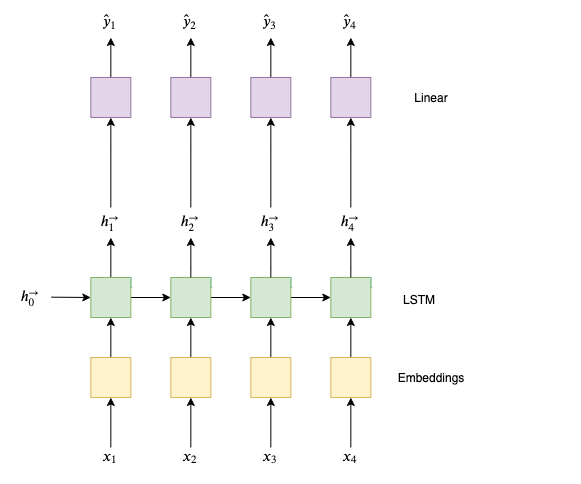

- [ ] Проверено на семинаре

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 8.1 MB/s eta 0:00:00


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torch as th

In [ ]:
class Model(nn.Module):
    def __init__(self, num_embeddings):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=500)
        self.rnn = nn.LSTM(input_size=500, hidden_size=200, batch_first=True)
        self.fc = nn.Linear(in_features=200, out_features=86)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=86, out_features=len(vocab_y.get_stoi()))
    def forward(self, X):
        out = self.emb(X)
        out, (h, c) = self.rnn(out)
        out = out.reshape(-1, 200)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
from torch.utils.data import DataLoader

dl_train = DataLoader(dset_train, batch_size=128)
dl_test = DataLoader(dset_test, batch_size=128)

In [ ]:
model = Model(len(vocab_X.get_stoi()))
model.to(device='cuda')

n_epochs = 2
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss(ignore_index=0)
losses = []

for epoch in range(n_epochs):
    train_losses = []
    acc_m = torchmetrics.Accuracy(task='multiclass', num_classes=len(vocab_y.get_stoi()), ignore_index=0)
    for X_, y_ in dl_train:
        out = model(X_.to(device='cuda'))
        loss = crit(out,th.flatten(y_).to(device='cuda'))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(loss)
        acc_m.update(out.argmax(dim=1).to(device='cpu'), th.flatten(y_))
    print(
        'epoch= ', epoch,
        'loss= ', th.tensor(train_losses).mean(),
        'accuracy= ', acc_m.compute()
        )

epoch=  0 loss=  tensor(0.1182) accuracy=  tensor(0.9588)
epoch=  1 loss=  tensor(0.0528) accuracy=  tensor(0.9831)


<p class="task" id="5"></p>

5\. Постройте и выведите на экран classification report на основе тестовой выборки. Выведите на экран пример предсказания частей речи обученной моделью.

- [ ] Проверено на семинаре

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
preds, trues = [], []
for X_test_, y_test_ in dl_test:
    out = model(X_test_.to(device='cuda'))
    preds.extend(
        th.argmax(out.to(device='cpu'), dim=1).detach().numpy().flatten()
        )
    trues.extend(
        y_test_.numpy().flatten()
        )

In [ ]:
print(
    classification_report(trues, preds, zero_division=True)
)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00    641213
           4       0.28      0.95      0.43    200174
           5       0.94      1.00      0.97    174036
           6       0.95      0.99      0.97    174024
           7       1.00      1.00      1.00    155201
           8       1.00      1.00      1.00    155201
           9       0.89      0.93      0.91     91304
          10       0.97      0.97      0.97     86819
          11       1.00      0.99      0.99     61599
          12       0.93      0.96      0.95     57898
          13       0.85      0.95      0.90     29056
          14       0.94      0.89      0.92     26548
          15       0.77      0.85      0.81      6455
          16       0.00      0.14      0.01      1105
          17       0.00      0.46      0.01       551
          18       0.55      0.30      0.39       435
          19       1.00      0.00      0.00       421
          20       0.39    

In [ ]:
example = X_test[2:10:2]
example_y = y_test[2:10:2]
example

[['<beg>', 'сегодня', 'догадался', 'выступить', '.', '<end>'],
 ['<beg>',
  'строительные',
  'работы',
  'выполнит',
  'китайская',
  'сторона',
  '.',
  '<end>'],
 ['<beg>',
  'теплые',
  'и',
  'родные',
  ',',
  'свидетели',
  'нашего',
  'счастья',
  '.',
  '<end>'],
 ['<beg>', 'совсем', 'не', 'нравилось', '.', '<end>']]

In [ ]:
ex_dset = POSTaggingDataset(example, example_y, vocab_X, vocab_y)

In [ ]:
outs = []
for expl, y in ex_dset:
    out = model(expl.to(device='cuda'))
    out = out.argmax(dim=1).to(device='cpu')
    outs.append(vocab_y.lookup_tokens(out.tolist()))

In [ ]:
import pandas as pd
import numpy as np

pd.DataFrame({
    'example': example,
    'preds': outs
})

,example,preds
0,"[<beg>, сегодня, догадался, выступить, ., <end>]","[<beg>, ADV, VERB, VERB, PUNCT, <end>, X, NOUN..."
1,"[<beg>, строительные, работы, выполнит, китайс...","[<beg>, ADJ, NOUN, VERB, ADJ, NOUN, PUNCT, <en..."
2,"[<beg>, теплые, и, родные, ,, свидетели, нашег...","[<beg>, ADJ, CONJ, ADJ, PUNCT, NOUN, ADJ, NOUN..."
3,"[<beg>, совсем, не, нравилось, ., <end>]","[<beg>, ADV, PART, VERB, PUNCT, <end>, LATN, N..."


<p class="task" id="6"></p>

6\. Решите задачи 4-5, используя двунаправленный рекуррентный слой.

![biLSTM](https://camo.githubusercontent.com/9bc90608fecf249e80f0ec0053469e91ff6347922aa136fda5bbec3de8303862/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d706f732d74616767696e672f626c6f622f6d61737465722f6173736574732f706f732d6269646972656374696f6e616c2d6c73746d2e706e673f7261773d31)

- [ ] Проверено на семинаре

In [ ]:
class Model(nn.Module):
    def __init__(self, num_embeddings):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=500)
        self.rnn = nn.LSTM(input_size=500,
                           hidden_size=200,
                           batch_first=True,
                           bidirectional=True)
        self.fc = nn.Linear(in_features=400, out_features=86)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=86, out_features=len(vocab_y.get_stoi()))
    def forward(self, X):
        out = self.emb(X)
        out, (h, c) = self.rnn(out)
        out = out.reshape(-1, 400)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
model = Model(len(vocab_X.get_stoi()))
model.to(device='cuda')

n_epochs = 2
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss(ignore_index=0)
losses = []

for epoch in range(n_epochs):
    train_losses = []
    acc_m = torchmetrics.Accuracy(task='multiclass', num_classes=len(vocab_y.get_stoi()), ignore_index=0)
    for X_, y_ in dl_train:
        out = model(X_.to(device='cuda'))
        loss = crit(out,th.flatten(y_).to(device='cuda'))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(loss)
        acc_m.update(out.argmax(dim=1).to(device='cpu'), th.flatten(y_))
    print(
        'epoch= ', epoch,
        'loss= ', th.tensor(train_losses).mean().item(),
        'accuracy= ', acc_m.compute().item()
        )

epoch=  0 loss=  0.10329122841358185 accuracy=  0.9666770696640015
epoch=  1 loss=  0.047413017600774765 accuracy=  0.9856590628623962


In [ ]:
preds, trues = [], []
for X_test_, y_test_ in dl_test:
    out = model(X_test_.to(device='cuda'))
    preds.extend(
        th.argmax(out.to(device='cpu'), dim=1).detach().numpy().flatten()
        )
    trues.extend(
        y_test_.numpy().flatten()
        )

In [ ]:
print(
    classification_report(trues, preds, zero_division=True)
)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00    641213
           4       0.99      0.97      0.98    200174
           5       1.00      1.00      1.00    174036
           6       0.98      0.98      0.98    174024
           7       1.00      1.00      1.00    155201
           8       1.00      1.00      1.00    155201
           9       0.91      0.96      0.94     91304
          10       0.96      0.98      0.97     86819
          11       1.00      1.00      1.00     61599
          12       0.10      0.97      0.18     57898
          13       0.67      0.97      0.79     29056
          14       0.89      0.87      0.88     26548
          15       0.07      0.87      0.13      6455
          16       0.74      0.19      0.30      1105
          17       0.26      0.44      0.32       551
          18       0.47      0.37      0.41       435
          19       0.31      0.20      0.24       421
          20       0.00    

In [ ]:
outs = []
for expl, y in ex_dset:
    out = model(expl.to(device='cuda'))
    out = out.argmax(dim=1).to(device='cpu')
    outs.append(vocab_y.lookup_tokens(out.tolist()))

In [ ]:
pd.DataFrame({
    'example': example,
    'preds': outs
})

,example,preds
0,"[<beg>, сегодня, догадался, выступить, ., <end>]","[<beg>, ADV, VERB, VERB, PUNCT, <end>, ADV, AD..."
1,"[<beg>, строительные, работы, выполнит, китайс...","[<beg>, ADJ, NOUN, VERB, ADJ, NOUN, PUNCT, <en..."
2,"[<beg>, теплые, и, родные, ,, свидетели, нашег...","[<beg>, ADJ, CONJ, ADJ, PUNCT, NOUN, ADJ, NOUN..."
3,"[<beg>, совсем, не, нравилось, ., <end>]","[<beg>, ADV, PART, VERB, PUNCT, <end>, INTJ, A..."


## Обратная связь
- [x] Хочу получить обратную связь по решению